# CENG403 - Spring 2024 - THE3

# Task 2: CNN with PyTorch
In this task, you will implement a convolutional neural network (CNN) with PyTorch.


## 2.1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [26]:
# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

## 2.2 Enable GPU

First, under "Edit -> Notebook Settings -> Hardware accelerator", select a GPU. With the following, we will inform PyTorch that we want to use the GPU.

In [27]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is not available :(


## 2.3 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset.

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2.3.1 Visualize Samples

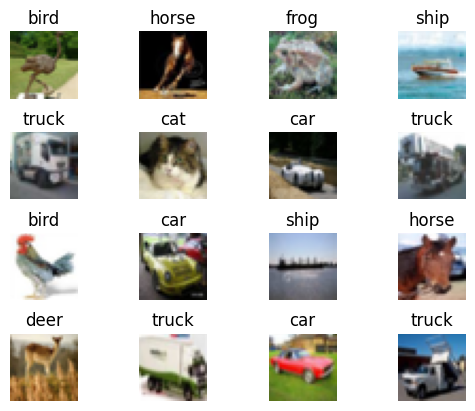

In [29]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = next(dataiter)
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 2.4 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 2.4.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels |
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size |
| ----| -----| ----|
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 |

You should choose suitable values for variables marked with `?' in the table and make sure that receptive fields can be properly placed in all layers.

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import random

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)
        # self.conv1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(in_channels=28, out_channels=32, kernel_size=5, stride = 1, padding = 0)
        # self.conv3 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding = 1)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride= 1 , padding=0)
        self.fc1 = nn.Linear(3200, 1500)
        self.fc2 = nn.Linear(1500, 10)
        ###########################################################
        # @TODO: Create the convolutional and FC layers as        #
        #  described above.                                       #
        ###########################################################

        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers. Note that x    #
      # needs to be reshaped to (batchsize, 3200) before        #
      # the FC layers.                                          #
      ###########################################################
        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor before feeding it into the fully connected layers
        x = x.view(x.size(0), -1)  # Flattening the tensor
        
        # Fully connected layers with ReLU and Softmax
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
      #######################################
      #                         END OF YOUR CODE                #
      ###########################################################
        return x

### 2.4.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [32]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

### 2.4.3 Create and visualize the model

In [ ]:
model = SmallCNN()

summary(model, input_size=(batch_size, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         1,216
├─Conv2d: 1-2                            [128, 32, 26, 26]         12,832
├─MaxPool2d: 1-3                         [128, 32, 12, 12]         --
├─Conv2d: 1-4                            [128, 32, 10, 10]         9,248
├─Linear: 1-5                            [128, 1500]               4,801,500
├─Linear: 1-6                            [128, 10]                 15,010
Total params: 4,839,806
Trainable params: 4,839,806
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.97
Input size (MB): 1.57
Forward/backward pass size (MB): 39.82
Params size (MB): 19.36
Estimated Total Size (MB): 60.75

### 2.4.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0025, momentum=0.99) # %47 accuracy
# optimizer = optim.SGD(model.parameters(), lr=0.0025, momentum=0.9) # %42 accuracy
# optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8) # %29 accuracy
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #%9 accuracy

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 2.0475870609283446
Epoch 1 / 10: avg. loss of last 5 iterations 2.018740487098694
Epoch 2 / 10: avg. loss of last 5 iterations 2.018710136413574
Epoch 3 / 10: avg. loss of last 5 iterations 1.9396651268005372
Epoch 4 / 10: avg. loss of last 5 iterations 1.9506200790405273
Epoch 5 / 10: avg. loss of last 5 iterations 1.9173032760620117
Epoch 6 / 10: avg. loss of last 5 iterations 1.9217105150222777
Epoch 7 / 10: avg. loss of last 5 iterations 1.910672163963318
Epoch 8 / 10: avg. loss of last 5 iterations 1.9587212085723877
Epoch 9 / 10: avg. loss of last 5 iterations 1.933370089530945


### 2.4.5 The Loss Curve

Let us visualize the loss curve.

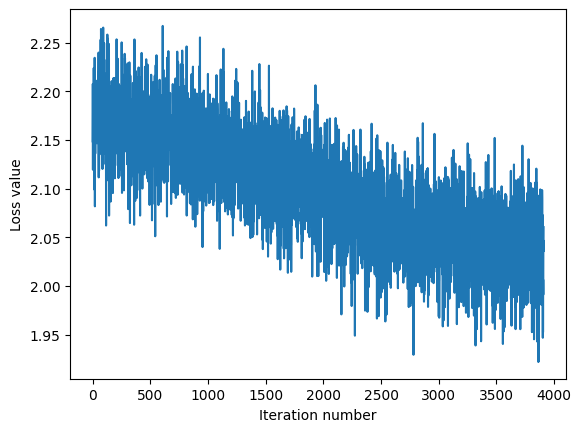

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.4.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


## 2.5 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Other than that, there is no restriction on what you can use in your CNN or how you can structure it.


### 2.5.1 Model Definition

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

class YourCNN(nn.Module):
    def __init__(self):
        super(YourCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)
        ###########################################################
        # @TODO: Create your layers here.#           
        #
        ###########################################################
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding = 1)
        # self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=1)
        # self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        # self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        # define the conv layer with 128 input 
        
        # self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        
        # self.fc1 = nn.Linear(3200,1500)
        # self.fc2 = nn.Linear(1500,10)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second Conv layer
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third, fourth, fifth Conv layers
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, bias=False)
        self.conv5_bn = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.3)
        
        # Fully Connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.fc2_bn = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 128)
        self.fc3_bn = nn.BatchNorm1d(128)
        self.dropout_fc3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 10)
        
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers.                #
      # @TODO : Use 3-maxpool, 2-maxpool #
      ###########################################################
        #   x = F.relu(self.conv1(x))
        #   x = F.relu(self.conv2(x))
        #   x = F.relu(self.conv3(x))
        #   x = F.relu(self.conv4(x))
        #   x = F.relu(self.conv5(x))
        #   x = self.maxpool=(x)
          
        #   x = x.view(x.size(0),-1)
          
        #   x = F.relu(self.fc1(x))
        #   x = F.softmax(self.fc2(x), dim=1)


                # First Conv layer
      x = self.conv1_bn(F.relu(self.conv1(x)))
      x = self.pool1(x)
      x = self.dropout1(x)
      
      # Second Conv layer
      x = self.conv2_bn(F.relu(self.conv2(x)))
      x = self.pool2(x)
      x = self.dropout2(x)
      
      # Third, fourth, fifth Conv layers
      x = self.conv3_bn(F.relu(self.conv3(x)))
      x = self.conv4_bn(F.relu(self.conv4(x)))
      x = self.conv5_bn(F.relu(self.conv5(x)))
      x = self.pool3(x)
      x = self.dropout3(x)
      
      # Flatten
      x = x.view(x.size(0), -1)
      
      # Fully Connected layers
      x = self.fc1_bn(F.relu(self.fc1(x)))
      x = self.dropout_fc1(x)
      
      x = self.fc2_bn(F.relu(self.fc2(x)))
      x = self.dropout_fc2(x)
      
      x = self.fc3_bn(F.relu(self.fc3(x)))
      x = self.dropout_fc3(x)
      
      x = self.fc4(x)
      
      x = F.log_softmax(x, dim=1)
      
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 2.5.2 Create and visuale your model

In [34]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 128, 32, 32]        3,456
├─BatchNorm2d: 1-2                       [128, 128, 32, 32]        256
├─MaxPool2d: 1-3                         [128, 128, 16, 16]        --
├─Dropout: 1-4                           [128, 128, 16, 16]        --
├─Conv2d: 1-5                            [128, 256, 16, 16]        294,912
├─BatchNorm2d: 1-6                       [128, 256, 16, 16]        512
├─MaxPool2d: 1-7                         [128, 256, 8, 8]          --
├─Dropout: 1-8                           [128, 256, 8, 8]          --
├─Conv2d: 1-9                            [128, 512, 8, 8]          1,179,648
├─BatchNorm2d: 1-10                      [128, 512, 8, 8]          1,024
├─Conv2d: 1-11                           [128, 512, 8, 8]          2,359,296
├─BatchNorm2d: 1-12                      [128, 512, 8, 8] 

### 2.5.3 Train the Model

In [33]:
import torch.optim as optim
import torch.nn as nn

model = YourCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)


model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 1.5650805950164794
Epoch 1 / 10: avg. loss of last 5 iterations 1.387878656387329
Epoch 2 / 10: avg. loss of last 5 iterations 1.1273556470870971
Epoch 3 / 10: avg. loss of last 5 iterations 1.1284887671470643
Epoch 4 / 10: avg. loss of last 5 iterations 1.1659400463104248


KeyboardInterrupt: 

### 2.5.4 Loss Curve

Let us visualize the loss curve.

In [35]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

NameError: name 'loss_history' is not defined

### 2.5.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [36]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# NOTES 
### -> TODO 5 layers - max pooling - fc layers with 0.002 lr and 0.99 momentum 
###
      # x = F.relu(self.conv1(x))
      # x = F.relu(self.conv2(x))
      # x = self.maxpool=(x)
      # x = F.relu(self.conv3(x))
      # x = F.relu(self.conv4(x))
      # x = self.maxpool=(x)
      # x = F.relu(self.conv5(x))
      
      # x = x.view(x.size(0),-1)
      
      # x = F.relu(self.fc1(x))
      # x = F.softmax(self.fc2(x), dim=1)
      
      #with
      #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
      
      #Accuracy of the network on the 10000 test images: 59%
###

###
      # x = F.relu(self.conv1(x))
      # x = F.relu(self.conv2(x))
      # x = self.maxpool=(x)
      # x = F.relu(self.conv3(x))
      # x = F.relu(self.conv4(x))
      # x = self.maxpool=(x)
      # x = F.relu(self.conv5(x))
      
      # x = x.view(x.size(0),-1)
      
      # x = F.relu(self.fc1(x))
      # x = F.softmax(self.fc2(x), dim=1)
      
      #with
      #optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.99)
      
      
      #Epoch 0 / 10: avg. loss of last 5 iterations 1.9228885412216186
      # Epoch 1 / 10: avg. loss of last 5 iterations 1.8792878150939942
      # Epoch 2 / 10: avg. loss of last 5 iterations 1.9454146862030028
      # Epoch 3 / 10: avg. loss of last 5 iterations 1.8946789741516112
      # Epoch 4 / 10: avg. loss of last 5 iterations 1.9100189208984375
      # Epoch 5 / 10: avg. loss of last 5 iterations 1.9368391513824463
      # Epoch 6 / 10: avg. loss of last 5 iterations 1.9208069801330567
      # Epoch 7 / 10: avg. loss of last 5 iterations 1.9715397596359252
      # Epoch 8 / 10: avg. loss of last 5 iterations 2.0558183670043944
      # Epoch 9 / 10: avg. loss of last 5 iterations 2.2013207912445067
      # kinda stuck in saddle point or smth else, try to use maxpoolings rarely
      #Accuracy of the network on the 10000 test images: %27
      
###

###
      # x = F.relu(self.conv1(x))
      # x = F.relu(self.conv2(x))
      # x = F.relu(self.conv3(x))
      # x = self.maxpool=(x)
      # x = F.relu(self.conv4(x))
      # x = F.relu(self.conv5(x))
      # x = self.maxpool=(x)
      
      # x = x.view(x.size(0),-1)
      
      # x = F.relu(self.fc1(x))
      # x = F.softmax(self.fc2(x), dim=1)
      
      #with
      #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
      
      #Accuracy of the network on the 10000 test images: %48
###

###
      # x = F.relu(self.conv1(x))
      # x = F.relu(self.conv2(x))
      # x = F.relu(self.conv3(x))
      # x = F.relu(self.conv4(x))
      # x = F.relu(self.conv5(x))
      # x = self.maxpool=(x)
      
      # x = x.view(x.size(0),-1)
      
      # x = F.relu(self.fc1(x))
      # x = F.softmax(self.fc2(x), dim=1)
      
      #with
      #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
      
      #Accuracy of the network on the 10000 test images: %53
###

###
      #https://www.kaggle.com/code/sid2412/cifar10-cnn-model-85-97-accuracy
###